<a href="https://colab.research.google.com/github/plance17/Aprendizaje-de-Maquina/blob/master/Redes_Neuronales_Gu%C3%ADa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchvision

In [2]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=4c8463716f4d284673457e4c2dc50ecfc95b9289a9548841f412bb907c8ab434
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from torchviz import make_dot
import pandas as pd
import torch.optim as optim

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [5]:
#Cargo la base de datos de FashionMNIST

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



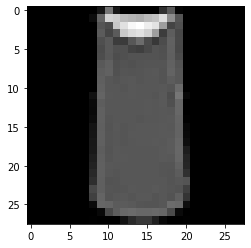

In [6]:
img=training_data[2][0]

#img  

plt.imshow(img.squeeze(), cmap="gray")
#plt.show()

In [7]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

training_data = CustomImageDataset(training_data)
test_data = CustomImageDataset(test_data)

In [9]:

#Tamaño de los batches
batch_size = 1000

#Núm de capas ocultas
n = 64

#Núm de épocas
epochs = 100

#dropout
p=0.1


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [77]:
class Autoencoder(nn.Module):
    def __init__(self,n=64,p=0.1):
        super(Autoencoder,self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(28*28,n)
        self.linear2 = nn.Linear(n,n)
        self.linear3 = nn.Linear(n,28*28)
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [78]:
model = Autoencoder().to(device)
print(model)

# Optimizamos los parámetros del modelo.
# Para ello, necesitamos definir una funcion error.
loss_fn = nn.MSELoss()

#Uso como optimizador el Método por el gradiente estocástico(SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=784, bias=True)
)


In [79]:
data=[]
columns  = ["n","epoch","batch_size","step","loss_train",
            "loss_test"]

data_64=[]
data_128=[]


#Num de capas ocultas
n=64
epochs=10
for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
        

#Entrenamiento        
      size = len(train_dataloader.dataset)
      model.train()
      for batch, (X, y) in enumerate(train_dataloader): #Ingreso la matriz (x,y). La función enumerate agrega una columna inicial (i,x,y) que numera los valores i=0,1,2,......
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss_t, current = loss.item(), batch * len(X)
            print(f"loss: {loss_t:>7f}  [{current:>5d}/{size:>5d}]")




#Test Grupo de entrenamiento
      num_samples = len(train_dataloader.dataset)
      num_batches = len(train_dataloader)
      model.eval()
      avrg_loss_train = 0
      with torch.no_grad():
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avrg_loss_train += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #Calculamos el nro de predicciones correctas, y lo acumulamos en el total
            #frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
      #calculamos la perdida total y la fraccion de clasificaciones correctas, y las imprimimos
      avrg_loss_train /= num_batches
      print(f"Avg loss(Train): {avrg_loss_train:>8f} \n")





#Test Grupo de validación
      num_samples = len(test_dataloader.dataset)
      num_batches = len(test_dataloader)
      model.eval()
      avrg_loss_test = 0
      with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avrg_loss_test += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #Calculamos el nro de predicciones correctas, y lo acumulamos en el total
            #frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
      #calculamos la perdida total y la fraccion de clasificaciones correctas, y las imprimimos
      avrg_loss_test /= num_batches
      print(f"Avg loss_test: {avrg_loss_test:>8f} \n")


      values = [n,t,batch_size,t,avrg_loss_train ,avrg_loss_test]
      data.append(dict(zip(columns, values)))


model_fname = "model-Adam-"+str(n)+"-"+str(epochs)+"-"+str(1)+"-"+str(batch_size)+".pth"
torch.save(model.state_dict(),model_fname)
#Guardamos los datos en pandas
model_fname = "model-Adam-"+str(n)+"-"+str(epochs)+"-"+str(1)+"-"+str(batch_size)+".csv"
df = pd.DataFrame()
df = df.append(data, True)
df.to_csv(model_fname)

Epoch 1
-------------------------------
loss: 0.212281  [    0/60000]
loss: 0.209398  [10000/60000]
loss: 0.205351  [20000/60000]
loss: 0.204218  [30000/60000]
loss: 0.205544  [40000/60000]
loss: 0.208183  [50000/60000]
Avg loss(Train): 0.204062 

Avg loss_test: 0.204098 

Epoch 2
-------------------------------
loss: 0.203008  [    0/60000]
loss: 0.202054  [10000/60000]
loss: 0.198518  [20000/60000]
loss: 0.197568  [30000/60000]
loss: 0.198772  [40000/60000]
loss: 0.201298  [50000/60000]
Avg loss(Train): 0.196739 

Avg loss_test: 0.196763 

Epoch 3
-------------------------------
loss: 0.196043  [    0/60000]
loss: 0.195002  [10000/60000]
loss: 0.191348  [20000/60000]
loss: 0.190077  [30000/60000]
loss: 0.191087  [40000/60000]
loss: 0.193080  [50000/60000]
Avg loss(Train): 0.187734 

Avg loss_test: 0.187737 

Epoch 4
-------------------------------
loss: 0.187755  [    0/60000]
loss: 0.186276  [10000/60000]
loss: 0.182244  [20000/60000]
loss: 0.180662  [30000/60000]
loss: 0.181116  [4

In [71]:
df

,n,epoch,batch_size,step,loss_train,loss_test
0,64,0,1000,0,0.203162,0.203161
1,64,1,1000,1,0.195276,0.195257
2,64,2,1000,2,0.185467,0.185421
3,64,3,1000,3,0.172422,0.172339
4,64,4,1000,4,0.155714,0.155588
...,...,...,...,...,...,...
95,64,95,1000,95,0.049385,0.049149
96,64,96,1000,96,0.049161,0.048926
97,64,97,1000,97,0.048965,0.048731
98,64,98,1000,98,0.048824,0.048591


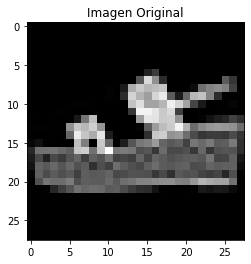

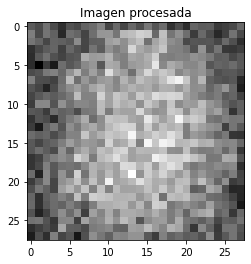

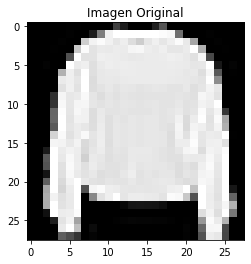

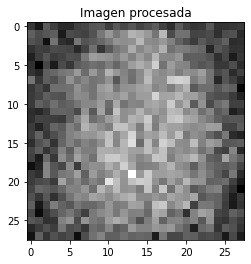

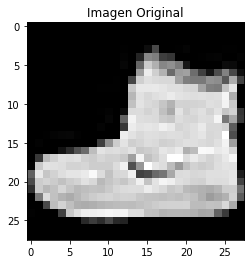

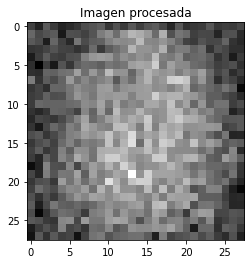

In [80]:
img=training_data[12][0]
img_pred=model(img)
img_pred=img_pred.detach().numpy().reshape((28,28))



plt.imshow(img.squeeze(), cmap='gray')
plt.title('Imagen Original')
plt.show()
plt.imshow(img_pred.squeeze(), cmap='gray')
plt.title('Imagen procesada')
plt.show()

img=training_data[7][0]
img_pred=model(img)
img_pred=img_pred.detach().numpy().reshape((28,28))



plt.imshow(img.squeeze(), cmap='gray')
plt.title('Imagen Original')
plt.show()
plt.imshow(img_pred.squeeze(), cmap='gray')
plt.title('Imagen procesada')
plt.show()

img=training_data[0][0]

img_pred=model(img)
img_pred=img_pred.detach().numpy().reshape((28,28))



plt.imshow(img.squeeze(), cmap='gray')
plt.title('Imagen Original')
plt.show()
plt.imshow(img_pred.squeeze(), cmap='gray')
plt.title('Imagen procesada')
plt.show()

In [73]:
df_64=df

In [67]:
df_128=df

In [61]:
df_256=df

In [55]:
df_512=df

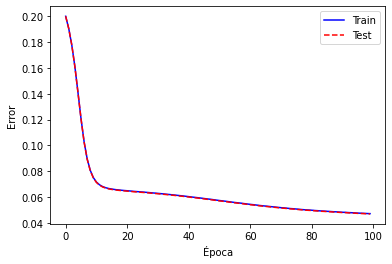

In [19]:
t=np.arange(0,100)

plt.plot(t,df_64.loss_train, '-b' ,label='Train')
plt.plot(t,df_64.loss_test, '--r' ,label='Test')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend(loc="upper right")
plt.show()

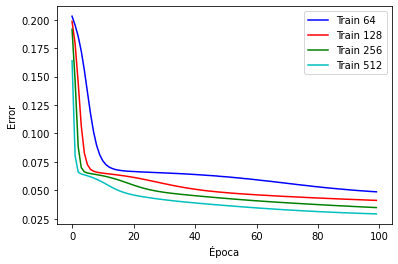

In [74]:
t=np.arange(0,100)

plt.plot(t,df_64.loss_train, '-b' ,label='Train 64')
plt.plot(t,df_128.loss_train, '-r' ,label='Train 128')
plt.plot(t,df_256.loss_train, '-g' ,label='Train 256')
plt.plot(t,df_512.loss_train, '-c' ,label='Train 512')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend(loc="upper right")
plt.show()

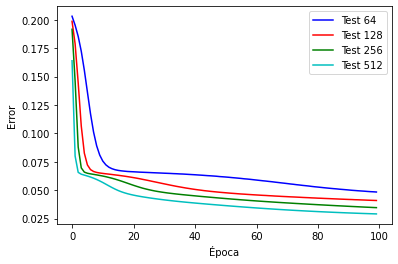

In [75]:
t=np.arange(0,100)

plt.plot(t,df_64.loss_test, '-b' ,label='Test 64')
plt.plot(t,df_128.loss_test, '-r' ,label='Test 128')
plt.plot(t,df_256.loss_test, '-g' ,label='Test 256')
plt.plot(t,df_512.loss_test, '-c' ,label='Test 512')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend(loc="upper right")
plt.show()

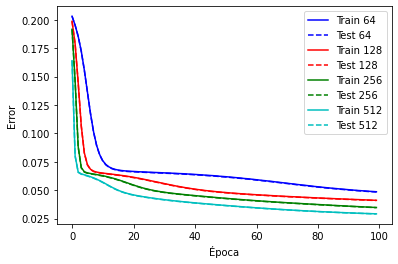

In [76]:
t=np.arange(0,100)

plt.plot(t,df_64.loss_train, '-b' ,label='Train 64')
plt.plot(t,df_64.loss_test, '--b' ,label='Test 64')
plt.plot(t,df_128.loss_train, '-r' ,label='Train 128')
plt.plot(t,df_128.loss_test, '--r' ,label='Test 128')
plt.plot(t,df_256.loss_train, '-g' ,label='Train 256')
plt.plot(t,df_256.loss_test, '--g' ,label='Test 256')
plt.plot(t,df_512.loss_train, '-c' ,label='Train 512')
plt.plot(t,df_512.loss_test, '--c' ,label='Test 512')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend(loc="upper right")
plt.show()